# Classification task

ref: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

## Import and Process Data

In [1]:
import glob
import numpy as np
import os
import shutil
np.random.seed(42)

In [2]:
files = glob.glob('train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12500)

In [3]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [4]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

## Prepare Datasets

In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [7]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1950, 150, 150, 3)


(150, 150, 3)


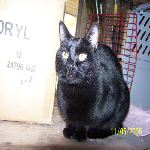

In [8]:
# Scale value from [0, 255] to [0, 1]
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [9]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog'] [0 0 0 0 0 1 1 1 1 1]


## Create CNN Model

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [12]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1950 samples
Epoch 1/30
3000/3000 [==============================] - 13s 4ms/sample - loss: 0.8043 - accuracy: 0.5737 - val_loss: 0.6551 - val_accuracy: 0.6210
Epoch 2/30
3000/3000 [==============================] - 9s 3ms/sample - loss: 0.6303 - accuracy: 0.6467 - val_loss: 0.5908 - val_accuracy: 0.6805
Epoch 3/30
3000/3000 [==============================] - 22s 7ms/sample - loss: 0.5630 - accuracy: 0.7163 - val_loss: 0.5575 - val_accuracy: 0.7154
Epoch 4/30
3000/3000 [==============================] - 60s 20ms/sample - loss: 0.5087 - accuracy: 0.7560 - val_loss: 0.5604 - val_accuracy: 0.7251
Epoch 5/30
3000/3000 [==============================] - 69s 23ms/sample - loss: 0.4286 - accuracy: 0.8023 - val_loss: 0.6096 - val_accuracy: 0.7169
Epoch 6/30
3000/3000 [==============================] - 55s 18ms/sample - loss: 0.3774 - accuracy: 0.8290 - val_loss: 0.5681 - val_accuracy: 0.7138
Epoch 7/30
3000/3000 [==============================] - 64s 21ms/sam

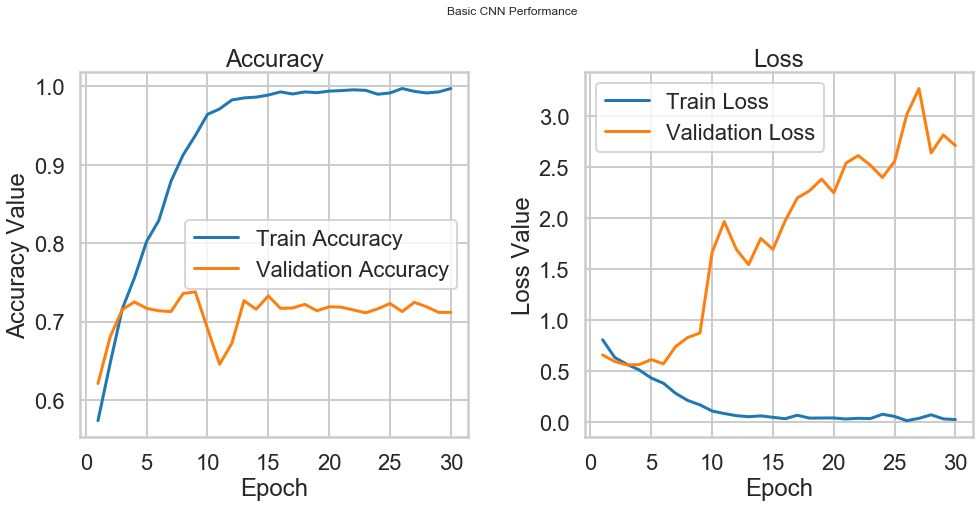

In [26]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), )
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Create CNN Model with regularizaton

In [27]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 15, 15, 128)      

In [28]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)         

Train on 3000 samples, validate on 1950 samples
Epoch 1/30
3000/3000 [==============================] - 16s 5ms/sample - loss: 0.7129 - accuracy: 0.5033 - val_loss: 0.6928 - val_accuracy: 0.5026
Epoch 2/30
3000/3000 [==============================] - 16s 5ms/sample - loss: 0.6889 - accuracy: 0.5370 - val_loss: 0.6882 - val_accuracy: 0.5210
Epoch 3/30
3000/3000 [==============================] - 15s 5ms/sample - loss: 0.6881 - accuracy: 0.5917 - val_loss: 0.6646 - val_accuracy: 0.5959
Epoch 4/30
3000/3000 [==============================] - 14s 5ms/sample - loss: 0.6471 - accuracy: 0.6190 - val_loss: 0.6145 - val_accuracy: 0.6626
Epoch 5/30
3000/3000 [==============================] - 14s 5ms/sample - loss: 0.6167 - accuracy: 0.6710 - val_loss: 0.5892 - val_accuracy: 0.6944
Epoch 6/30
3000/3000 [==============================] - 13s 4ms/sample - loss: 0.5701 - accuracy: 0.7080 - val_loss: 0.5887 - val_accuracy: 0.6892
Epoch 7/30
3000/3000 [==============================] - 16s 5ms/sample

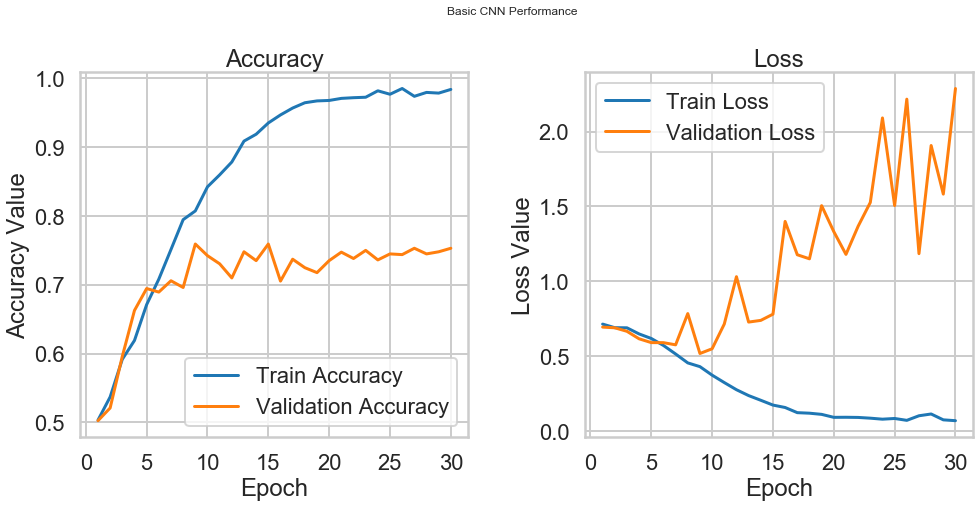

In [29]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), )
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [31]:
model.save("cats_dogs_basic_cnn.h5")

## CNN Model with Image Augmentation

Create new training data with transforms of original data. Leave validation unchanged (except for normalization)

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

In [35]:
# img_id = 2595
# cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
#                                    batch_size=1)
# cat = [next(cat_generator) for i in range(0,5)]
# fig, ax = plt.subplots(1,5, figsize=(16, 6))
# print('Labels:', [item[1][0] for item in cat])
# l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

In [37]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)    

Epoch 1/100
100/100 [==============================] - 18s 181ms/step - loss: 0.6948 - accuracy: 0.5103 - val_loss: 0.6950 - val_accuracy: 0.4940
Epoch 2/100
100/100 [==============================] - 15s 149ms/step - loss: 0.6870 - accuracy: 0.5470 - val_loss: 0.6838 - val_accuracy: 0.5100
Epoch 3/100
100/100 [==============================] - 17s 166ms/step - loss: 0.6702 - accuracy: 0.5910 - val_loss: 0.6699 - val_accuracy: 0.5810
Epoch 4/100
100/100 [==============================] - 17s 170ms/step - loss: 0.6582 - accuracy: 0.5983 - val_loss: 0.7908 - val_accuracy: 0.5240
Epoch 5/100
100/100 [==============================] - 16s 161ms/step - loss: 0.6489 - accuracy: 0.6127 - val_loss: 0.7840 - val_accuracy: 0.5350
Epoch 6/100
100/100 [==============================] - 16s 162ms/step - loss: 0.6472 - accuracy: 0.6137 - val_loss: 0.6383 - val_accuracy: 0.6150
Epoch 7/100
100/100 [==============================] - 16s 162ms/step - loss: 0.6387 - accuracy: 0.6233 - val_loss: 0.6620 -

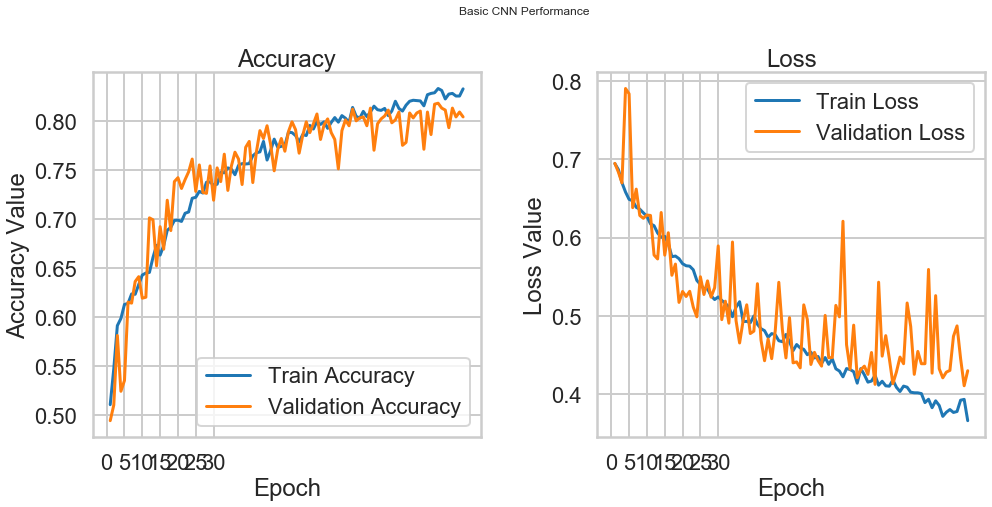

In [41]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), )
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [42]:
model.save("cats_dogs_cnn_img_aug.h5")

# Transfer Learning

## Use large VGG-16 CNN model, freeze convolution blocks

In [43]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras as keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

58892288/58889256 [==============================] - 26s 0us/step


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x00000237B454D0B8>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000237B4A27668>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000237B4660160>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000237B4A354E0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000237B4A354A8>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000237B4655C88>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000237B4635F28>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000237B4635E80>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000237B4956748>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000237B493D9B0>,block3_conv3,False


(1, 4, 4, 512)


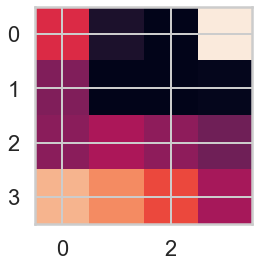

In [51]:
# Sample 'bottleneck' (feature map after VGG16 model but before fully connected network classifier) feature
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [52]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1950, 8192)


In [55]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1950 samples
Epoch 1/30
3000/3000 [==============================] - 2s 653us/sample - loss: 0.4155 - accuracy: 0.7993 - val_loss: 0.3098 - val_accuracy: 0.8595
Epoch 2/30
3000/3000 [==============================] - 1s 357us/sample - loss: 0.2819 - accuracy: 0.8803 - val_loss: 0.3259 - val_accuracy: 0.8590
Epoch 3/30
3000/3000 [==============================] - 1s 358us/sample - loss: 0.2373 - accuracy: 0.9007 - val_loss: 0.2850 - val_accuracy: 0.8805
Epoch 4/30
3000/3000 [==============================] - 1s 352us/sample - loss: 0.2008 - accuracy: 0.9160 - val_loss: 0.2964 - val_accuracy: 0.8774
Epoch 5/30
3000/3000 [==============================] - 1s 361us/sample - loss: 0.1656 - accuracy: 0.9350 - val_loss: 0.3056 - val_accuracy: 0.8764
Epoch 6/30
3000/3000 [==============================] - 1s 360us/sample - loss: 0.1421 - accuracy: 0.9440 - val_loss: 0.3171 - val_accuracy: 0.8795
Epoch 7/30
3000/3000 [==============================] - 1s 364us

In [57]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

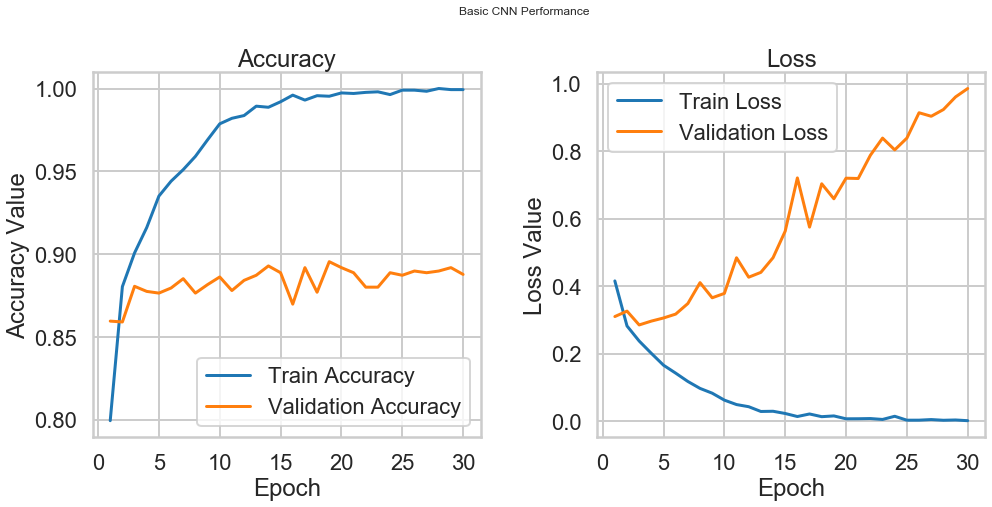

In [58]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), )
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### With Image augmentation

In [59]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [ ]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)   

Epoch 1/100
100/100 [==============================] - 97s 971ms/step - loss: 0.6650 - accuracy: 0.6113 - val_loss: 0.5023 - val_accuracy: 0.7900
Epoch 2/100
 13/100 [==>...........................] - ETA: 1:11 - loss: 0.5763 - accuracy: 0.7308